In [67]:
import os
import shutil

# === Paths ===
input_dir = "./real-noise-files/"
output_dir = "./dataset/real-noise-files/"
os.makedirs(output_dir, exist_ok=True)

# === Threshold for size check (800 KB) ===
MIN_SIZE_KB = 800

# === Move Valid Files ===
moved = 0
skipped = 0

for filename in os.listdir(input_dir):
    if not filename.endswith(".txt"):
        continue

    full_path = os.path.join(input_dir, filename)
    file_size_kb = os.path.getsize(full_path) / 1024

    if file_size_kb >= MIN_SIZE_KB:
        shutil.copy(full_path, os.path.join(output_dir, filename))
        moved += 1
    else:
        skipped += 1
        print(f" Skipping {filename}: only {file_size_kb:.1f} KB")

print(f"\n Done! {moved} files moved to '{output_dir}'")
print(f" {skipped} files were too small and skipped.")


❌ Skipping real_noise_0.txt: only 464.0 KB
❌ Skipping real_noise_1009.txt: only 464.0 KB
❌ Skipping real_noise_1022.txt: only 464.0 KB
❌ Skipping real_noise_1035.txt: only 464.0 KB
❌ Skipping real_noise_1044.txt: only 464.0 KB
❌ Skipping real_noise_1049.txt: only 464.0 KB
❌ Skipping real_noise_1065.txt: only 464.0 KB
❌ Skipping real_noise_1077.txt: only 464.0 KB
❌ Skipping real_noise_1079.txt: only 464.0 KB
❌ Skipping real_noise_1093.txt: only 464.0 KB
❌ Skipping real_noise_110.txt: only 464.0 KB
❌ Skipping real_noise_1121.txt: only 464.0 KB
❌ Skipping real_noise_113.txt: only 464.0 KB
❌ Skipping real_noise_1138.txt: only 464.0 KB
❌ Skipping real_noise_1139.txt: only 464.0 KB
❌ Skipping real_noise_1167.txt: only 464.0 KB
❌ Skipping real_noise_1176.txt: only 464.0 KB
❌ Skipping real_noise_1179.txt: only 464.0 KB
❌ Skipping real_noise_1193.txt: only 464.0 KB
❌ Skipping real_noise_1196.txt: only 464.0 KB
❌ Skipping real_noise_1207.txt: only 464.0 KB
❌ Skipping real_noise_1211.txt: only 46

In [70]:
import os
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma
from pycbc.types import FrequencySeries
from gwpy.timeseries import TimeSeries
from pycbc import distributions
from tqdm import tqdm
from astropy import units as u  # Fixes t0 unit mismatch

# === Parameters ===
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(fs * duration)
flow = 30.0
target_snr_range = (8, 12)
input_noise_dir = "./dataset/real-noise-files/"
output_dir = "./injected-dataset/"
os.makedirs(output_dir, exist_ok=True)

signal_dir = os.path.join(output_dir, "signal")
injected_dir = os.path.join(output_dir, "injected")
noise_dir = os.path.join(output_dir, "noise")
for d in [signal_dir, injected_dir, noise_dir]:
    os.makedirs(d, exist_ok=True)

# === Mass Distribution ===
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))

# === Start Loop ===
files = sorted([f for f in os.listdir(input_noise_dir) if f.endswith('.txt')])
for idx, filename in tqdm(enumerate(files), total=len(files)):
    try:
        # Load and preprocess real noise
        noise_path = os.path.join(input_noise_dir, filename)
        noise_ts = TimeSeries.read(noise_path)
        noise_ts = noise_ts.taper('leftright', duration=0.5)
        noise_ts = noise_ts.bandpass(35, 350)
        noise_ts = noise_ts.crop(noise_ts.t0.value, noise_ts.t0.value + 4.0)
        noise = noise_ts.to_pycbc()

        # Sample BBH parameters
        m1, m2 = mass_dist.rvs(size=1)[0]
        distance = 1
        inclination = np.random.uniform(0, np.pi)
        spin1z = np.random.uniform(-0.99, 0.99)
        spin2z = np.random.uniform(-0.99, 0.99)

        # Generate waveform
        hp, _ = get_td_waveform(approximant="SEOBNRv2",
                                mass1=m1, mass2=m2,
                                delta_t=delta_t,
                                f_lower=40.0,
                                distance=distance,
                                inclination=inclination,
                                spin1z=spin1z,
                                spin2z=spin2z)

        # Convert to frequency domain
        ht = hp.to_frequencyseries()

        # === PSD with matched delta_f ===
        delta_f_wave = ht.delta_f
        flen = int(2048 / delta_f_wave) + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f_wave, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=delta_f_wave)

        # === Compute SNR and scale ===
        snr_orig = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr_orig) or snr_orig == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr_orig

        # Convert to TimeSeries
        signal_ts = TimeSeries.from_pycbc(hp)
        injection_time = np.random.choice([1.0, 1.5, 2.0, 2.5, 3.0])
        signal_ts.t0 = noise_ts.t0 + injection_time * u.second  # ✅ Fix: use Quantity

        # Inject signal into noise
        injected_ts = noise_ts.inject(signal_ts)

        # Save outputs
        signal_ts.write(os.path.join(signal_dir, f"bbh_signal_{idx}.txt"))
        injected_ts.write(os.path.join(injected_dir, f"merged_noise_signal_{idx}.txt"))
        noise_ts.write(os.path.join(noise_dir, f"real_noise_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Skipping index {idx} due to error: {e}")


  0%|          | 2/4480 [00:01<1:01:32,  1.21it/s]/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: divide by zero encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)
/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: invalid value encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)
100%|██████████| 4480/4480 [38:29<00:00,  1.94it/s] 


In [71]:
import csv
import pandas as pd

In [72]:
#Merging the injected signal into single CSV file
path = "./injected-dataset/injected/"
files= os.listdir(path)
f = open("./injected-dataset/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4313/4313 [04:19<00:00, 16.64it/s]


In [73]:
#Merging the noise into single CSV file
path = "./injected-dataset/noise/"
files= os.listdir(path)
f = open("./injected-dataset/Final_Merged_Noise_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    if 1 in df.columns:
        c = df[1]
    else:
        c = df[0]
    #c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4313/4313 [02:52<00:00, 25.04it/s]


In [74]:
#Merging the signal into single CSV file
path = "./injected-dataset/signal/"
files= os.listdir(path)
f = open("./injected-dataset/Final_Merged_bbh_Signal_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4313/4313 [00:20<00:00, 214.92it/s]


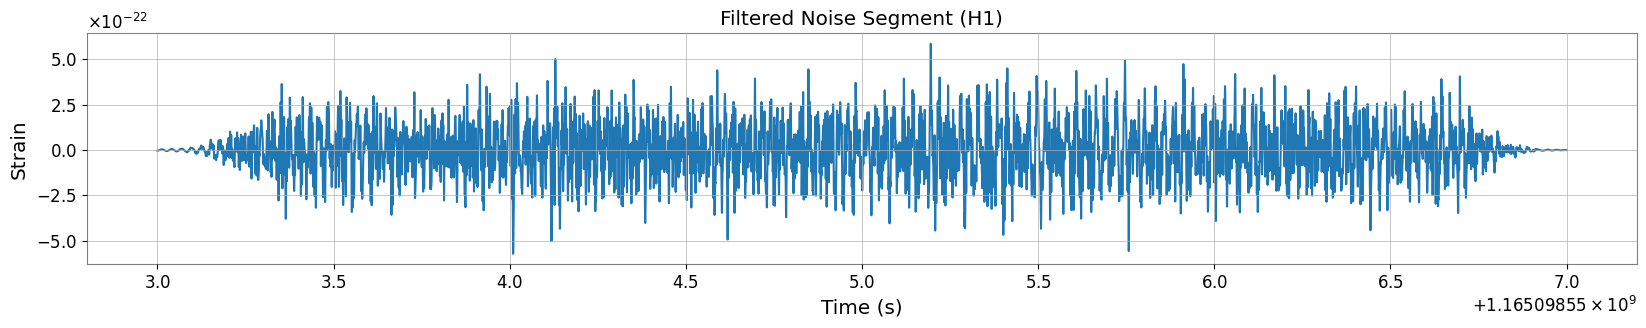

In [3]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries as GTimeSeries

ts = GTimeSeries.read('./dataset/real-noise-files/real_noise_4.txt')
ts = ts.taper('leftright', duration=0.5)     # Taper first and last 0.5s
ts = ts.bandpass(35, 350)                    # Bandpass filter
ts = ts.crop(ts.t0.value, ts.t0.value + 4.0) # cropping if needed

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Filtered Noise Segment (H1)")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

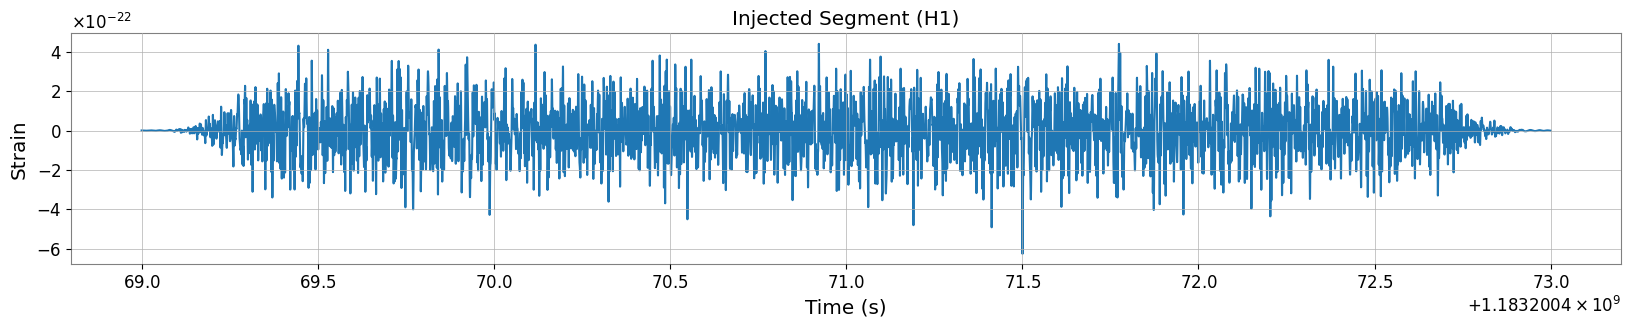

In [2]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries as GTimeSeries


ts = GTimeSeries.read('./injected-dataset/injected/merged_noise_signal_1.txt')
ts = ts.crop(ts.t0.value, ts.t0.value + 4.0)

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Injected Segment (H1)")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()